In [5]:
import geopandas as gpd
import pandas as pd
import contextily as cx
import numpy as np
from pointpats import centrography
from shapely.geometry import Point
import matplotlib.pyplot as plt
from scipy import stats
import shapely as shapely

In [1]:
pip install rpy2

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext rpy2.ipython

Unable to determine R library path: Command '('C:\\Users\\p7j5p\\miniconda3\\envs\\info615\\lib\\R\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.
C:\Users\p7j5p\miniconda3\envs\info615\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
%%R
library(stringr)
library(plyr)
library(readr)
library(data.table)
library(tidyverse)
library(readxl)
library(dplyr)
library(sp)
library(sf)
library(gstat)
library(ggplot2)
library(DataCombine)

R[write to console]: Linking to GEOS 3.9.0, GDAL 3.2.1, PROJ 7.2.1



In [ ]:
#begin by downloading the full list of GHCND stations and inventory, then renaming the columns
%%R
url = "ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
url1 = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt"
dest = "C:/Users/p7j5p/Documents/Paul's reports/spatial statistics/final project data/stations.csv"
dest2 = "C:/Users/p7j5p/Documents/Paul's reports/spatial statistics/final project data/inventory.csv"
download.file(url, dest)
download.file(url1, dest2)
#stations needs to be read back in because I separated the data into separate columns in excel
stations <- read_table2("Paul's reports/spatial statistics/final project data/stations.csv")

inventory <- read_table2("inventory.csv")

stations$name <- str_c(stations$ST, " ", stations$JOHNS, " ", stations$COOLIDGE, " ", stations$FLD)

names(stations)[names(stations)=="ACW00011604"] <- "GHCND"
names(stations)[names(stations)=="ST JOHNS COOLIDGE FLD"] <- "name"
names(stations)[names(stations)=="17.1167"] <- "Lat"
names(stations)[names(stations)=="-61.7833"] <- "Long"
names(inventory)[names(inventory)=="ACW00011604"] <- "GHCND"
names(inventory)[names(inventory)=="17.1167"] <- "Lat"
names(inventory)[names(inventory)=="TMAX"] <- "Elem"
names(inventory)[names(inventory)=="-61.7833"] <- "Long"
names(inventory)[names(inventory)=="1949"] <- "First"
names(inventory)[names(inventory)=="1949_1"] <- "Last"

In [ ]:
%%R
#Now filter down to the states for this analysis

stations_states <- stations %>% filter(grepl("US1CO|US1ID|US1UT|US1WY", GHCND))

stations_states2 <- select(stations_states, GHCND, Lat, Long)
#stations_states2 contains our coordinate pairs for each station in our list
write.csv(stations_states2, "stations_states2.csv")

inventory_states <- inventory %>% filter(grepl("US1CO|US1ID|US1UT|US1WY", GHCND))

inventory_states1 <- inventory_states %>% filter(inventory_states$Elem == 'SNOW')

station_list <- select(inventory_states1, GHCND)

In [ ]:
%%R
#This section of code originally came from http://spatialreasoning.com/wp/20170307_1244_r-reading-filtering-weather-data-from-the-global-historical-climatology-network-ghcnd
# and was written by Rao, M & Battaile, B.  I modified it slightly for this project

noaa_dir <- "ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/all/"
noaaout <- "C:/Users/p7j5p/Documents/Paul's reports/spatial statistics/final project data/indv files"


numFiles <- length(station_list$GHCND)
dirname <- noaa_dir
#need to have libcurl enabled due to the volume of files ~4600
options(download.file.method="libcurl")

for (i in 1:numFiles) {
  infile <- paste0(dirname, station_list$GHCND[i], ".dly")
  outfile <- paste0(noaaout, station_list$GHCND[i], ".csv")
  cols <- c( "A11", "I4", "I2", "A4",
             rep( c( "I5", "A1", "A1", "A1"), 31) )
  df <- read.fortran(infile, cols, na.strings="-9999") # -9999 indicates missing data
  
  # next, fill in the column names
  tmp <- c("Val","xxM","xxQ","xxS") # xx so we can ditch them later
  vhdrs <- paste(   rep(tmp,31),   rep(1:31,each=4), sep="")
  hdrs <- c("ID", "year", "month", "element", vhdrs)
  names(df) <- hdrs
  df <- df[df$year >= 1995 & df$year <= 2020,]
  df_out <- dplyr::select(df, -matches("xx*")) # get rid of M, Q, S 
  write.csv(df_out, outfile)
}

In [ ]:
%%R
#now combining the downloaded files into a single csv
file_list <- list.files("C:/Users/p7j5p/Documents/Paul's reports/spatial statistics/final project data")
#the wd needs to be set to the folder containing the files for this to run
Combined_data <- ldply(list.files(), read.csv, header=TRUE)

write.csv(Combined_data, "Combined_data.csv")

Combined_data1 <- Combined_data %>% filter(!(month %in% (5:12)))

Combined_data1 <- Combined_data1 %>% filter(element == 'SNOW')

write.csv(Combined_data1, 'snow_data.csv')

Switching back to python for the next section of the script. Snow_data_transposed is 'snow_data' that was written to a CSV.  This was then taken to openrefine and the data was reformatted from wide to long and then filled down and saved

In [6]:
coords = gpd.read_file(r"C:\Users\p7j5p\Documents\Paul's reports\Data analysis\stations_states2.csv")
data = gpd.read_file(r"C:\Users\p7j5p\Documents\Paul's reports\spatial statistics\snow_data_transposed.csv")

starting off with the masterfile of all stations for the date and area ranges

In [19]:
df = data.merge(coords, on='ID')

In [20]:
df

,ID,year,month,element,Date,Amt (mm),geometry_x,Lat,Long,geometry_y
0,US1COAD0001,2002,1,SNOW,Val1,13,None,39.946,-104.6088,None
1,US1COAD0001,2002,1,SNOW,Val2,NA,None,39.946,-104.6088,None
2,US1COAD0001,2002,1,SNOW,Val3,0,None,39.946,-104.6088,None
3,US1COAD0001,2002,1,SNOW,Val4,0,None,39.946,-104.6088,None
4,US1COAD0001,2002,1,SNOW,Val5,NA,None,39.946,-104.6088,None
...,...,...,...,...,...,...,...,...,...,...
2507058,US1WYWS0030,2020,4,SNOW,Val27,NA,None,44.1263,-104.3947,None
2507059,US1WYWS0030,2020,4,SNOW,Val28,NA,None,44.1263,-104.3947,None
2507060,US1WYWS0030,2020,4,SNOW,Val29,NA,None,44.1263,-104.3947,None
2507061,US1WYWS0030,2020,4,SNOW,Val30,NA,None,44.1263,-104.3947,None


In [21]:
df = df[['ID', 'year', 'month', 'element', 'Date', 'Amt (mm)', 'Lat', 'Long']]

In [22]:
df

,ID,year,month,element,Date,Amt (mm),Lat,Long
0,US1COAD0001,2002,1,SNOW,Val1,13,39.946,-104.6088
1,US1COAD0001,2002,1,SNOW,Val2,NA,39.946,-104.6088
2,US1COAD0001,2002,1,SNOW,Val3,0,39.946,-104.6088
3,US1COAD0001,2002,1,SNOW,Val4,0,39.946,-104.6088
4,US1COAD0001,2002,1,SNOW,Val5,NA,39.946,-104.6088
...,...,...,...,...,...,...,...,...
2507058,US1WYWS0030,2020,4,SNOW,Val27,NA,44.1263,-104.3947
2507059,US1WYWS0030,2020,4,SNOW,Val28,NA,44.1263,-104.3947
2507060,US1WYWS0030,2020,4,SNOW,Val29,NA,44.1263,-104.3947
2507061,US1WYWS0030,2020,4,SNOW,Val30,NA,44.1263,-104.3947


In [25]:
geom = gpd.points_from_xy(df['Long'], df['Lat'])

Making the geodataframe and formatting the CRS

In [26]:
gdf = gpd.GeoDataFrame(df, geometry=geom)

In [28]:
gdf

,ID,year,month,element,Date,Amt (mm),Lat,Long,geometry
0,US1COAD0001,2002,1,SNOW,Val1,13,39.946,-104.6088,POINT (-104.60880 39.94600)
1,US1COAD0001,2002,1,SNOW,Val2,NA,39.946,-104.6088,POINT (-104.60880 39.94600)
2,US1COAD0001,2002,1,SNOW,Val3,0,39.946,-104.6088,POINT (-104.60880 39.94600)
3,US1COAD0001,2002,1,SNOW,Val4,0,39.946,-104.6088,POINT (-104.60880 39.94600)
4,US1COAD0001,2002,1,SNOW,Val5,NA,39.946,-104.6088,POINT (-104.60880 39.94600)
...,...,...,...,...,...,...,...,...,...
2507058,US1WYWS0030,2020,4,SNOW,Val27,NA,44.1263,-104.3947,POINT (-104.39470 44.12630)
2507059,US1WYWS0030,2020,4,SNOW,Val28,NA,44.1263,-104.3947,POINT (-104.39470 44.12630)
2507060,US1WYWS0030,2020,4,SNOW,Val29,NA,44.1263,-104.3947,POINT (-104.39470 44.12630)
2507061,US1WYWS0030,2020,4,SNOW,Val30,NA,44.1263,-104.3947,POINT (-104.39470 44.12630)


In [32]:
gdf.crs = 4326

In [33]:
print(gdf.crs)

epsg:4326


In [34]:
gdf = gdf.to_crs("EPSG:6933")

In [38]:
gdf.to_file(r"C:\Users\p7j5p\Documents\Paul's reports\spatial statistics\indv files\stations.geojson", driver='GeoJSON')

C:\Users\p7j5p\miniconda3\envs\info615\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


I was running low on memory and had to restart my kernal so I needed to reload the data here

In [30]:
gdf2 = gpd.read_file(r"C:\Users\p7j5p\Documents\Paul's reports\spatial statistics\indv files\stations.geojson")

In [46]:
gdf2.dtypes

ID            object
year          object
month         object
element       object
Date          object
Amt (mm)     float64
Lat           object
Long          object
geometry    geometry
dtype: object

In [ ]:
gdf2['Amt (mm)'] = pd.to_numeric(gdf2['Amt (mm)'], errors='coerce')

In [34]:
gdf2 = gdf2.dropna(subset=['Amt (mm)'])

Here I am cleaning the data down to only values that a greater than zero so the krieg will work

In [47]:
gdf3 = gdf2

In [51]:
gdf3 = gdf3.loc[(gdf3['Amt (mm)'] > 0)]

In [52]:
gdf3

,ID,year,month,element,Date,Amt (mm),Lat,Long,geometry
0,US1COAD0001,2002,1,SNOW,Val1,13.0,39.946,-104.6088,POINT (-10093313.994 4701775.544)
9,US1COAD0001,2002,1,SNOW,Val10,104.0,39.946,-104.6088,POINT (-10093313.994 4701775.544)
55,US1COAD0001,2002,2,SNOW,Val25,38.0,39.946,-104.6088,POINT (-10093313.994 4701775.544)
56,US1COAD0001,2002,2,SNOW,Val26,13.0,39.946,-104.6088,POINT (-10093313.994 4701775.544)
62,US1COAD0001,2002,3,SNOW,Val1,89.0,39.946,-104.6088,POINT (-10093313.994 4701775.544)
...,...,...,...,...,...,...,...,...,...
2506966,US1WYWS0029,2020,3,SNOW,Val28,13.0,43.7019,-104.6947,POINT (-10101602.165 5060908.463)
2506971,US1WYWS0029,2020,4,SNOW,Val2,64.0,43.7019,-104.6947,POINT (-10101602.165 5060908.463)
2506981,US1WYWS0029,2020,4,SNOW,Val12,64.0,43.7019,-104.6947,POINT (-10101602.165 5060908.463)
2507014,US1WYWS0030,2018,1,SNOW,Val14,71.0,44.1263,-104.3947,POINT (-10072656.281 5100163.709)


In [53]:
gdf3.to_file(r"C:\Users\p7j5p\Documents\Paul's reports\spatial statistics\indv files\stations_full.geojson", driver='GeoJSON')

C:\Users\p7j5p\miniconda3\envs\info615\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Now we are ready to krieg, back to R

In [4]:
%%R
setwd("~/Paul's reports/spatial statistics/indv files")

In [5]:
%%R
stations_full <- read_sf("stations_full.geojson")

In [13]:
%%R
#colnm = colnames(stations_full)
#colnm #if you need to confirm col names
names(stations_full)[names(stations_full)=='Amt..mm.'] <- 'Amt'

In [15]:
%%R
stations_full <- as_Spatial(stations_full)

In [16]:
%%R
stations.grid <- makegrid(stations_full, cellsize = 5000) # cell size in map projection units, in this case meters
stations.grid <- as_Spatial(st_as_sf(stations.grid, coords = c("x1", "x2"), crs = 6933, agr = "constant"))
#plot(stations.grid)

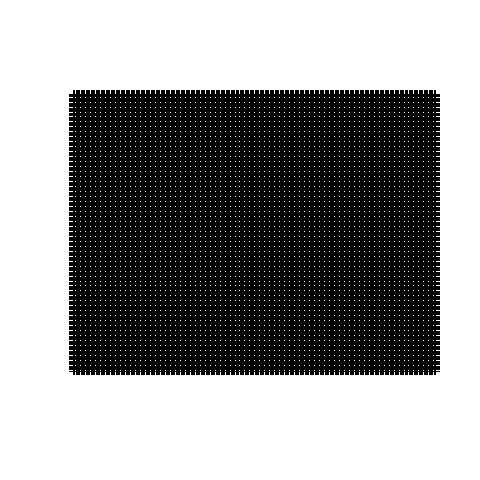

In [17]:
%%R
plot(stations.grid)

In [19]:
%%R
stations_full.vgm <- variogram(Amt~1, stations_full)

In [21]:
%%R
stations_full.fit <- fit.variogram(stations_full.vgm, model=vgm(1, "Lin", 2500, 1))

In [ ]:
%%R
stations_full.kriged <- st_as_sf(krige(Amt ~ 1, stations_full, stations.grid, model=stations_full.fit, nmax=25))

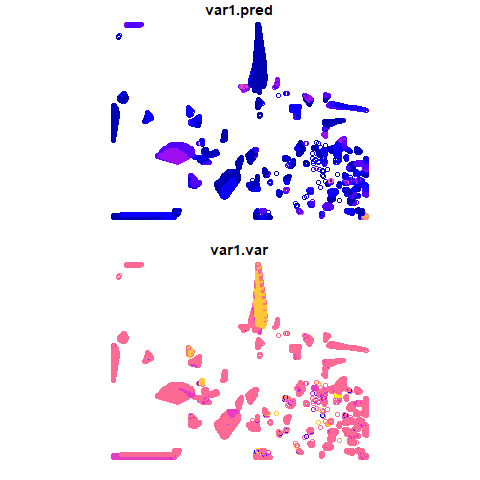

In [16]:
%%R
plot(kriged)

In [27]:
%%R
st_write(stations_full.kriged, "kriging_results.geojson")

Writing layer `kriging_results' to data source 
  `kriging_results.geojson' using driver `GeoJSON'
Writing 64380 features with 2 fields and geometry type Point.


This section was purely to test if my krige went correctly, not necessary as the regular plot should show it

In [51]:
%%R
kriged1 <- read_sf("kriging_results.geojson")

In [55]:
%%R
print(kriged1)

Simple feature collection with 64380 features and 4 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -11290000 ymin: 4404000 xmax: -9845000 ymax: 5509000
Projected CRS: WGS 84 / NSIDC EASE-Grid 2.0 Global
# A tibble: 64,380 x 5
   var1.pred var1.var            geometry       lon     lat
 *     <dbl>    <dbl>         <POINT [m]>     <dbl>   <dbl>
 1        48     2.67 (-11290000 4404000) -11290000 4404000
 2        48     2.67 (-11285000 4404000) -11285000 4404000
 3        48     2.67 (-11280000 4404000) -11280000 4404000
 4        48     2.67 (-11275000 4404000) -11275000 4404000
 5        48     2.67 (-11270000 4404000) -11270000 4404000
 6        48     2.67 (-11265000 4404000) -11265000 4404000
 7        48     2.67 (-11260000 4404000) -11260000 4404000
 8        48     2.67 (-11255000 4404000) -11255000 4404000
 9        48     2.67 (-11250000 4404000) -11250000 4404000
10        48     2.67 (-11245000 4404000) -11245000 4404000
# ... with 64,370 more rows


In [36]:
%%R
kriged$lat <- as.integer(kriged$lat)
kriged$lon <- as.integer(kriged$lon)
kriged$var1.pred <- as.integer(kriged$var1.pred)
kriged$var1.var <- as.integer(kriged$var1.var)

In [54]:
%%R
kriged1 <- kriged1 %>%
  dplyr::mutate(lon = sf::st_coordinates(.)[,1],
                lat = sf::st_coordinates(.)[,2])

In [56]:
%%R
kriged2 <- as.data.frame(kriged1)

In [41]:
%%R
kriged$lat <- as.numeric(kriged$lat)
kriged$lon <- as.numeric(kriged$lon)
kriged$var1.pred <- as.numeric(kriged$var1.pred)
kriged$var1.var <- as.numeric(kriged$var1.var)

#meltDF$variable=as.numeric(levels(meltDF$variable))[meltDF$variable]
kriged$lat=as.numeric(levels(kriged$lat))[kriged$lat]

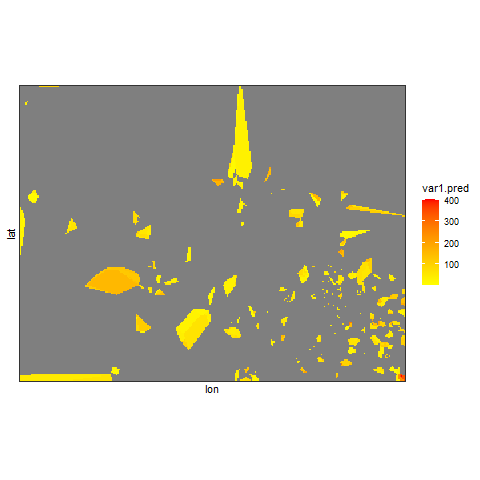

In [59]:
%%R
kriged2 %>% as.data.frame %>%
  ggplot(aes(x=lon, y=lat)) + geom_tile(aes(fill=var1.pred)) + coord_equal() +
  scale_fill_gradient(low = "yellow", high="red") +
  scale_x_discrete() + scale_y_discrete() +
  theme_bw()